# Diffusion

## Forward Diffusion Process:

$$x_{t} = \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} \epsilon \qquad \epsilon \sim N(0, I)$$

Variance preserving

$$x_{t-1} \sim N(0, I) \implies \text{Var}[x_t] = (1 - \beta_t) + \beta_t = 1$$

Sampling $x_t$ in a single step:

$$\text{Let } \alpha_t = 1 - \beta_t, \qquad \bar \alpha_t = \prod_{t=1}^T \alpha_t$$

$$
\begin{align*}

x_t &= \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} \epsilon \\

&= \sqrt{1 - \beta_t} \left[ \sqrt{1 - \beta_{t-1}} x_{t-2} + \sqrt{\beta_{t-1}} \epsilon \right] + \sqrt{\beta_t} \epsilon \\

&= \sqrt{1 - \beta_t} \sqrt{1 - \beta_{t-1}} x_{t-2} + \sqrt{1 - \beta_t} \sqrt{\beta_{t-1}} \epsilon + \sqrt{\beta_t} \epsilon \\

&= \sqrt{\alpha_t \alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}} \epsilon \\

x_t &= \sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} \epsilon \\
\end{align*}
$$

## Reverse Diffusion Process:

Train a neural network that models:

$$p_\theta(x_{t-1} | x_t) = N(\mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$

$$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar \alpha_t}} \epsilon_\theta(x_t, t) \right)$$

Loss:

$$
\begin{align*}

L &= \mathbb{E} \left[ \frac{(1-\alpha_t)^2}{2 \alpha_t (1 - \bar \alpha_t) ||\Sigma_\theta||^2}
||\epsilon - \epsilon_\theta(\sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} \epsilon, t)||^2 \right] \\ \\

L_\text{simple} &= \mathbb{E} \left[ ||\epsilon - \epsilon_\theta(\sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} \epsilon, t)||^2 \right]

\end{align*}
$$

Sampling:

$$
\begin{align*}
& x_T \sim N(0, I) \\

& \text{for t in T..1}: \\
& \qquad \epsilon \sim N(0, I) \ \text{ if } t > 1 \ \text{ else } 0 \\
& \qquad x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar \alpha_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t \epsilon

\end{align*}
$$

Alternate interpretation of diffusion from Langevin Dynamics: diffusion models learn $\nabla_x \log p(x)$, the way the image should be perturbed (denoised) to make it match the data distribution.

What does the reweighted objective $L_\text{simple}$ change? First we must schedule $\beta_t$

## $\beta_t$ schedule

Desmos plots: https://www.desmos.com/calculator/74swzuyya5

$$\alpha_t = \text{max}(\frac{\bar \alpha_t}{\bar \alpha_{t-1}}, 0.001) \qquad \beta_t = 1 - \alpha_t$$

$$\bar \alpha_t = \frac{f(t)}{f(0)} \qquad f(t) = \cos^2 \left( \frac{t / T + s}{1 + s} \cdot \frac{\pi}{2} \right)$$

This noise schedule strongly prioritizes the low noise regime, very gradually increasing noise for a long time, and only adding a lot of noise only for $t$ very close to the $T$. This schedule makes the model spend less time denoising extremely noisy images, which doesn't matter as much as denoising coherent images.

So back to the important question: What does the reweighted objective $L_\text{simple}$ change?

The scaling term dropped by the reweighted objective is

$$\frac{(1-\alpha_t)^2}{2 \alpha_t (1 - \bar \alpha_t) ||\Sigma_\theta||^2}$$

This term is very very small until it blows up when $t$ gets close to $T$. By removing this weighting term, we are again decreasing the importance the model gives to denoising extremely noisy images and focusing the model on more meaningful denoising steps.

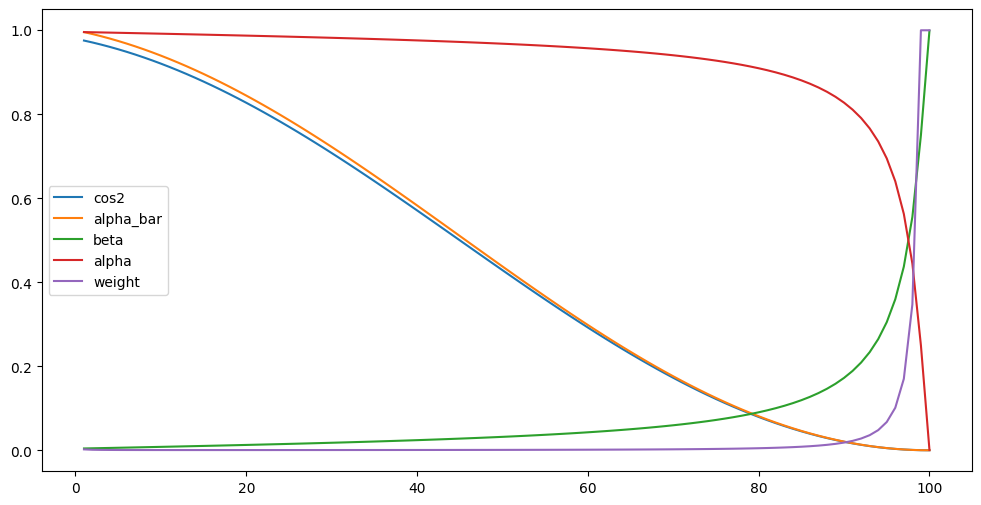

In [1]:
import torch
import matplotlib.pyplot as plt


def calc_cos_schedule(t: torch.Tensor, T: int, s: float = 0.1) -> torch.Tensor:
    phase = ((t / T) + s) / (1 + s)
    return torch.cos(phase * (torch.pi / 2.0)) ** 2.0

def calc_alpha_bar(t: torch.Tensor, T: int) -> torch.Tensor:
    return calc_cos_schedule(t, T) / calc_cos_schedule(torch.tensor(0.0), T)

def calc_alpha(t: torch.Tensor, T: int) -> torch.Tensor:
    a = calc_alpha_bar(t, T) / calc_alpha_bar(t - 1, T)
    return torch.maximum(a, torch.tensor(0.001))

def calc_beta(t: torch.Tensor, T: int) -> torch.Tensor:
    # a = alpha_bar(t, T) / alpha_bar(t - 1, T)
    # return torch.minimum(1 - a, torch.tensor(0.999))
    return 1 - calc_alpha(t, T)


T = 100
t = torch.arange(1, T + 1)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t, calc_cos_schedule(t, T), label="cos2")

alpha_bar = calc_alpha_bar(t, T)
ax.plot(t, alpha_bar, label="alpha_bar")

ax.plot(t, calc_beta(t, T), label="beta")

alpha = calc_alpha(t, T)
ax.plot(t, alpha, label="alpha")

dropped_weight = ((1 - alpha) ** 2) / (2 * alpha * (1 - alpha_bar))
dropped_weight.clip_(max=1)
ax.plot(t, dropped_weight, label="weight")

ax.legend()
plt.show()

torch.Size([60000, 1, 28, 28])


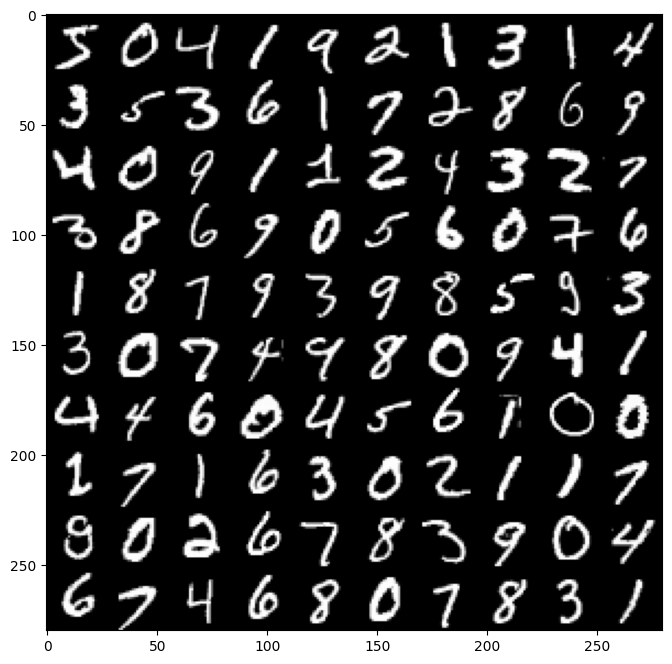

In [2]:
from torchvision.datasets import MNIST
from einops import rearrange


ds = MNIST(root="data", train=True, download=True)
images, labels = ds.data, ds.targets

images = images.to(dtype=torch.float32)
# images = (images - images.mean()) / images.std()
# print(images.mean(), images.std())
images = (images / (255 / 2)) - 1
images = images.unsqueeze(-3)
print(images.shape)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rearrange(images[:100], "(n b) c h w -> (n h) (b c w)", n=10), cmap="grey");
plt.show()

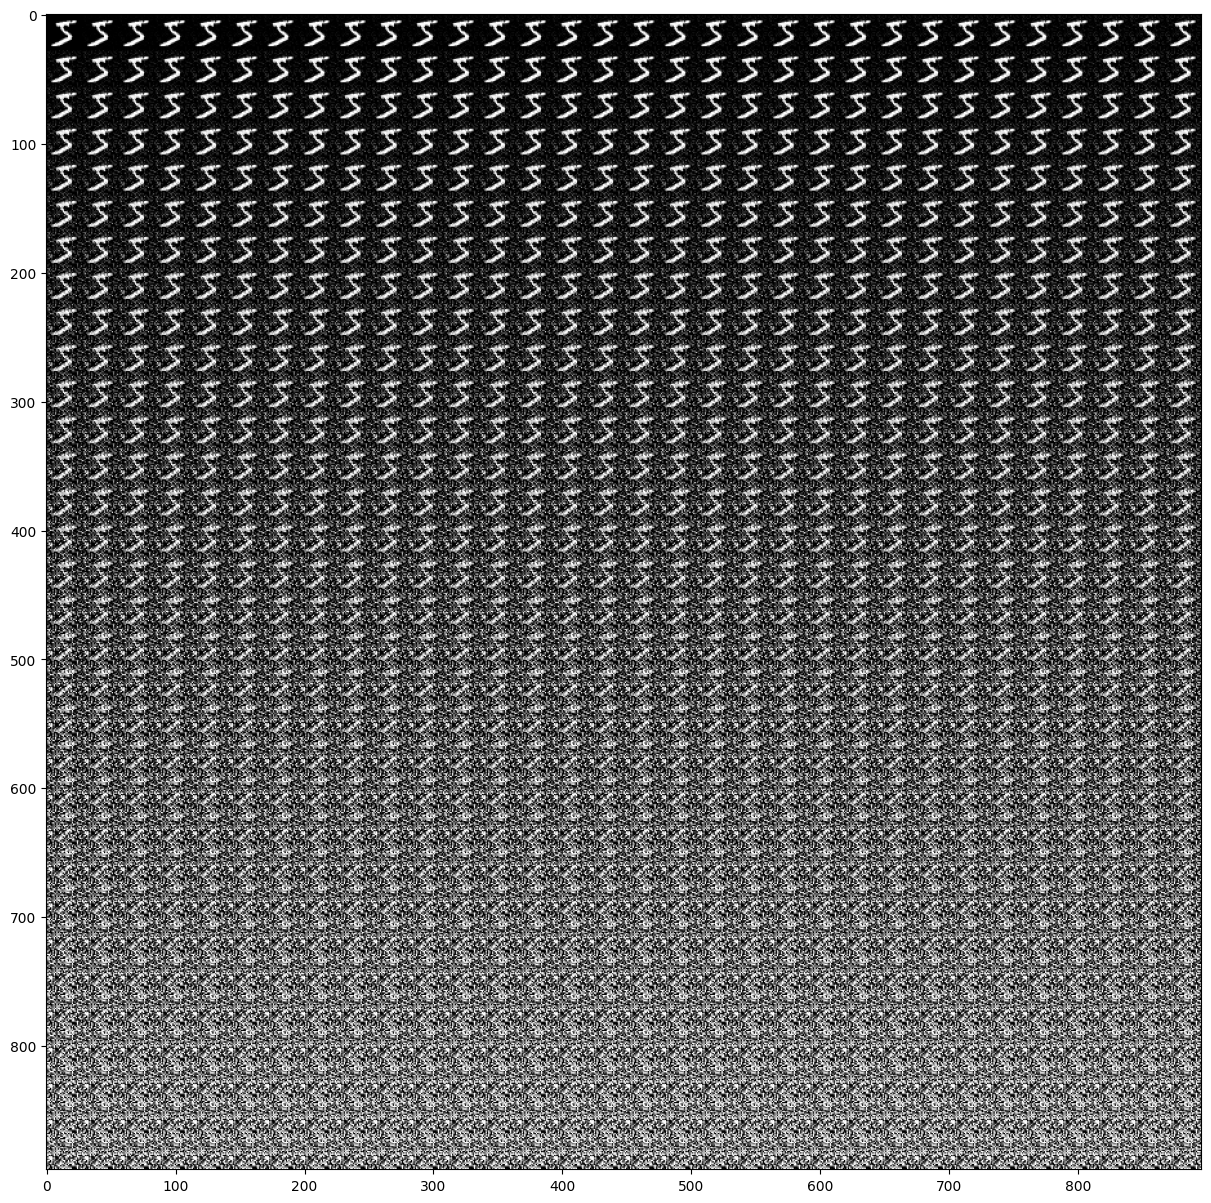

In [3]:
def add_noise(xs: torch.Tensor, t: torch.Tensor, T: int) -> tuple[torch.Tensor, torch.Tensor]:
    alpha_bars = calc_alpha_bar(t, T)
    alpha_bars = rearrange(alpha_bars, "b -> b 1 1 1")
    noise = (1 - alpha_bars).sqrt() * torch.randn_like(xs)
    return noise, (alpha_bars.sqrt() * xs) + noise


T = 1024
_, noised = add_noise(images[:1], torch.arange(T), T)
noised.clip_(-1, 1)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(rearrange(noised, "(n b) c h w -> (n h) (b c w)", n=32), cmap="grey");
plt.show()

## Model

* Unet: unmasked PixelCNN++
* groupnorm
* time: transformer sin pos embedding
* self atten at 16x16 feature map
* cifar10 35.7M params
* T=1000

0    : 23568.404
100  : 2145.419
200  : 1455.357
300  : 1095.951
400  : 810.924
500  : 760.399
600  : 1059.619
700  : 662.193
800  : 872.128
900  : 616.540
1000 : 590.857


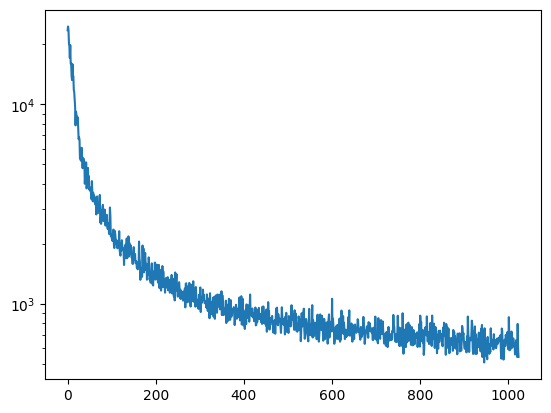

In [4]:
from torch import nn
from torch.optim import Adam


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_emb_dim: int, max_pool: bool = False, up_conv: bool = False):
        super().__init__()
        assert not (max_pool and up_conv), "Cannot max pool and up conv."
        self.in_channels, self.out_channels, self.max_pool, self.up_conv = in_channels, out_channels, max_pool, up_conv

        conv_out_channels = out_channels * 2 if up_conv else out_channels
        self.conv_out_channels = conv_out_channels
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, conv_out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(conv_out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(conv_out_channels, conv_out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(conv_out_channels),
            nn.ReLU()
        )

        self.time_proj = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.ReLU(),
            nn.Linear(time_emb_dim * 4, conv_out_channels)
        )

        if in_channels == conv_out_channels:
            self.passthrough = nn.Identity()
        else:
            self.passthrough = nn.Conv2d(in_channels, conv_out_channels, kernel_size=3, stride=1, padding=1, bias=False)

        self.post = nn.Identity()
        if max_pool:
            self.post = nn.MaxPool2d(2, 2)
        elif up_conv:
            self.post = nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv2d(conv_out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )

    def forward(self, xb: torch.Tensor, time_emb: torch.Tensor):
        z = self.conv1(xb)
        time_emb = rearrange(self.time_proj(time_emb), "b t -> b t 1 1")
        z = self.conv2(z + time_emb)
        z = z + self.passthrough(xb)
        post = self.post(z)
        return (z, post)
    

class PosEnc(nn.Module):
    def __init__(self, max_time: int, time_emb_dim: int):
        super().__init__()
        self.pos_enc = torch.empty((max_time, time_emb_dim), dtype=torch.float32)
        pos = torch.arange(max_time)
        divs = 10000 ** (torch.arange(time_emb_dim) / time_emb_dim)
        self.pos_enc[pos, ::2] = torch.sin(pos[:, None] / divs[::2])
        self.pos_enc[pos, 1::2] = torch.cos(pos[:, None] / divs[1::2])

    def forward(self, t: torch.Tensor):
        # t - 1 b/c t sampled from [1, T].
        return self.pos_enc[t - 1]


class UNet(nn.Module):
    def __init__(self, max_time: int, time_emb_dim: int):
        super().__init__()
        self.down_conv1 = ConvBlock(1, 8, time_emb_dim, max_pool=True)
        self.down_conv2 = ConvBlock(8, 16, time_emb_dim, max_pool=True)

        self.bottleneck = ConvBlock(16, 32, time_emb_dim)

        self.up_conv1 = ConvBlock(32, 16, time_emb_dim, up_conv=True)
        self.up_conv2 = ConvBlock(32, 8, time_emb_dim, up_conv=True)

        self.out_conv = ConvBlock(16, 16, time_emb_dim)
        self.to_pix = nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1, bias=True)

        self.pos_enc = nn.Sequential(
            PosEnc(max_time, time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.GELU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

    def forward(self, xb: torch.Tensor, t: torch.Tensor):
        time_emb = self.pos_enc(t)
        res1, down1 = self.down_conv1(xb, time_emb)
        res2, down2 = self.down_conv2(down1, time_emb)
        _, z = self.bottleneck(down2, time_emb)
        _, up2 = self.up_conv1(z, time_emb)
        _, up1 = self.up_conv2(torch.cat((up2, res2), dim=1), time_emb)
        _, pre_out = self.out_conv(torch.cat((up1, res1), dim=1), time_emb)
        out = self.to_pix(pre_out)
        return out


N_EPOCHS = 1024
BATCH_SIZE = 32
MAX_DIFFUSION_STEPS = 1024
LR = 3e-4
TIME_EMB_DIM = 32

model = UNet(MAX_DIFFUSION_STEPS, TIME_EMB_DIM)
optim = Adam(model.parameters(), lr=LR)

losses = []
for epoch in range(N_EPOCHS):
    xb = images[torch.randint(len(images), (BATCH_SIZE,))]

    t = torch.randint(1, MAX_DIFFUSION_STEPS + 1, (BATCH_SIZE,))
    noise, xb_noised = add_noise(xb, t, MAX_DIFFUSION_STEPS)

    pred_noise = model(xb_noised, t)

    loss = ((noise - pred_noise) ** 2.0).sum()
    optim.zero_grad()
    loss.backward()
    optim.step()

    losses.append(loss.item())
    if (epoch % 100) == 0:
        print(f"{str(epoch):<5}: {loss.item():.3f}")

plt.plot(losses)
plt.yscale("log")
plt.show()